In [1]:
!pip install -U hopsworks --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.2/170.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 59.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 5.0 MB/s eta 0:00:00
  Preparing metadat

In [2]:
import hopsworks
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [3]:
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

In [4]:
project = hopsworks.login()
fs = project.get_feature_store()

Copy your Api Key (first register/login): https://c.app.hopsworks.ai/account/api/generated

Paste it here: ··········
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/188566
Connected. Call `.close()` to terminate connection gracefully.


In [5]:
wine_fg = fs.get_feature_group(name="wine_bin_classify_269", version=1) #"wine_bin_classify_269"
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine_bin_classify_269",
                                  version=1,
                                  description="Read from Wine Quality dataset",
                                  labels=["quality"],
                                  query=query)

In [6]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)
X_train.info()

Finished: Reading data from Hopsworks, using ArrowFlight (0.67s) 
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4236 entries, 0 to 5294
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  4236 non-null   float64
 1   fixed_acidity         4236 non-null   float64
 2   volatile_acidity      4236 non-null   float64
 3   citric_acid           4236 non-null   float64
 4   residual_sugar        4236 non-null   float64
 5   chlorides             4236 non-null   float64
 6   free_sulfur_dioxide   4236 non-null   float64
 7   total_sulfur_dioxide  4236 non-null   float64
 8   density               4236 non-null   float64
 9   ph                    4236 non-null   float64
 10  sulphates             4236 non-null   float64
 11  alcohol               4236 non-null   float64
dtypes: float64(12)
memory usage: 430.2 KB


In [7]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
#model = KNeighborsClassifier(n_neighbors=30)
model.fit(X_train, y_train.values.ravel())

RandomForestClassifier(random_state=42)

In [8]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)
print(y_pred.size)
results

1059


array([[809,  29],
       [145,  76]])

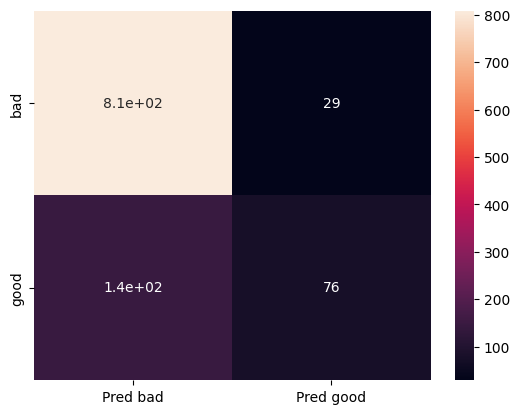

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
df_cm = pd.DataFrame(results, ['bad','good'],
                     ['Pred bad', 'Pred good'])
cm = sns.heatmap(df_cm, annot=True)
fig = cm.get_figure()

In [10]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'iris_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
iris_model = mr.python.create_model(
    name="wine_model",
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
iris_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/6816553 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/16865 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/1070 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/188566/models/wine_model/2


Model(name: 'wine_model', version: 2)